# Assignment 1
## Cameron Wolfe 9/25/2023

### Imports

In [64]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

### Helper Functions

In [2]:
def nim_sum(piles):
    nim_sim = 0
    for p in piles:
        nim_sim = nim_sim ^ p

    return nim_sim

def mex(values):
    i = 0
    while i in values:
        i = i+1
    return i

### Nim Player
Given an input of the form (c1, c2, ..., cn) which represents the starting point of an n-column nim game, write a program that computes a winning first move(s).

In [22]:
# Takes the current state of the game (n > 0 piles with x >= 0 chips in each pile) 
# and returns a list of tuples containing the pile to take from and the number of 
# chips to take.  Returns an empty list if there are no winning moves (in a P-position)
def nim_player(piles):

    # Get nim sum of game
    current_nim_sum = nim_sum(piles)
    moves = []
    # If nim_sum != 0, then game is in a N position so find winning moves, else there are no winning moves so return an empty list
    if current_nim_sum != 0:
        # Go through all piles
        for index in range(len(piles)):

            # If a valid move exists in that pile that puts the game into a P postion, then do that move
            pile_nim_sum = nim_sum((piles[index], current_nim_sum))
            if pile_nim_sum <= piles[index]:
                chips = piles[index] - pile_nim_sum
                moves.append((index, chips))
    
    return moves

### G-Function Calculator
Using a programming language of your choice and a representation of a graph also of your choice, write a program that computes the g-value of each vertex of finite, acyclic graph and determines whether each position in that graph is a P-position or N-position.

Graph Vertices and Edges:
1: [2, 3]
2: [3, 4]
3: [6]
4: [5]
5: []
6: [7]
7: [8, 9]
8: []
9: [15]
12: []
13: [12]
14: [13, 12]
15: [14, 12, 13]
G-function:
1: 2
2: 0
3: 1
4: 1
5: 0
6: 0
7: 1
8: 0
9: 0
12: 0
13: 1
14: 2
15: 3
P-positions: [2, 5, 6, 8, 9, 12]
N-positions: [1, 3, 4, 7, 15, 14, 13]


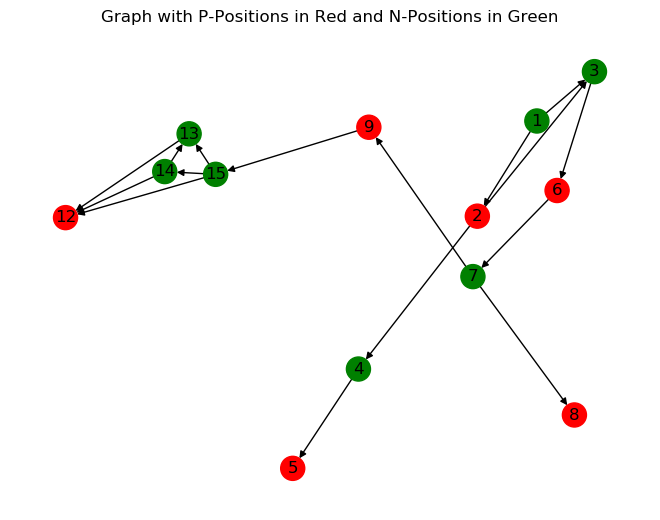

In [51]:
# Graph class
class Graph():
    
    # Graph starts out as empty
    def __init__(self):
        self.vertices = dict()
        self.g_function = dict()
        self.P = []
        self.N = []

    # Add vertices to graph, ensuring there are no duplicates
    def add_vertex(self, vertex):
        if not vertex in self.vertices:
            self.vertices[vertex] = []
            self.g_function[vertex] = -1

    # Add a directed edge between vertices, making sure that both vertices are part of the graph
    # and adding them if they are not
    def add_edge(self, vertex_1, vertex_2):
        if not vertex_1 in self.vertices:
            self.add_vertex(vertex_1)

        if not vertex_2 in self.vertices:
            self.add_vertex(vertex_2)
        
        # Uses neighbor list (or follower list) to define graph
        if not vertex_2 in self.vertices[vertex_1]:
            self.vertices[vertex_1].append(vertex_2)

    # Returns a new graph who's edges are in the opposite direction of the current graph
    def reverse_graph(self):
        G = Graph()
        
        for v_1 in self.vertices:
            for v_2 in self.vertices[v_1]:
                G.add_edge(v_2, v_1)
    
        return G

    # Print out the graph
    def print_graph(self):
        print("Graph Vertices and Edges:")
        for v in sorted(self.vertices):
            print(str(v) + ":", self.vertices[v])
        print("G-function:")
        for v in sorted(self.vertices):
            print(str(v) + ":", self.g_function[v])
        print('P-positions:', self.P)
        print('N-positions:', self.N)

    # Depth first search is used in the g_function calculation to get a topological order
    def DFS(self, vertices, visited=-1, t=-1, first=-1, last=-1):
        # DFS has not been called yet, so initialize all of the information needed to run it
        if visited == -1 or t == -1 or first == -1 or last == -1:
            visited = {}
            first = {}
            last = {}
            t = 0

            for v in self.vertices:
                visited[v] = 0
                first[v] = 0
                last[v] = 0
        
        # A single vertex has been given, so go through all of its neighbors and recursively call DFS on them
        if len(vertices) == 1:
            vertex = vertices[0]
            t = t + 1
            first[vertex] = t
            visited[vertex] = 1
            for v in self.vertices[vertex]:
                if visited[v] == 0:
                    [visited, t, first, last] = self.DFS([v], visited, t, first, last)

            t = t + 1
            last[vertex] = t

        # A list of vertices has been given, so go through the list and call DFS on each vertex given it hasn't been visited
        else:
            for v in vertices:
                if visited[v] == 0:
                    [visited, t, first, last] = self.DFS([v], visited, t, first, last)

        # Useful information from DFS
        return [visited, t, first, last]

    # Goes through all vertices and calculates the g_function using the recursive definition
    # NOTE: graph must be acyclic
    def calculate_g_function(self):
        
        # Use DFS to get a topological order of the graph
        [_, _, _, last] = self.DFS(self.vertices)

        # Extract topological order from lasts and reverse it so 
        # forall x,y in V if (x,y) in E then y is before x in order (edges go from right to left) 
        reverse_top_order = [value[0] for value in sorted(last.items(), key=lambda item: item[1], reverse=False)]

        # Calculate g_function recursively
        for v in reverse_top_order:
            # Base case
            if self.vertices[v] == []:
                self.g_function[v] = 0
            else:
                values = []
                for neighbor in self.vertices[v]:
                    values.append(self.g_function[neighbor])
                self.g_function[v] = mex(values)
    
    # Go through vertices and, using g_function, get P and N sets
    def get_P_and_N_positions(self):

        self.P = []
        self.N = []

        for vertex in self.vertices:
            if self.g_function[vertex] == 0:
                self.P.append(vertex)
            else:
                self.N.append(vertex)

    # Use networkx to get a pretty picture
    def visualize(self, start=-1):
        edge_list = []

        for vertex in self.vertices:
            for neighbor in self.vertices[vertex]:
                edge_list.append([vertex, neighbor])
        
        if not (self.P and self.N):
            self.get_P_and_N_positions()

        node_colors = {}
        node_edge_colors = {}
        label_colors = {}
        for v in self.P:
            node_colors[v] = 'red'
            label_colors[v] = 'black'
            node_edge_colors[v] = 'gray'
        for v in self.N:
            node_colors[v] = 'green'
            #label_colors[v] = 'white'
            node_edge_colors[v] = 'gray'
        
        if start != -1:
            node_edge_colors[start] = 'green'

        G = nx.DiGraph()
        G.add_edges_from(edge_list)
        nx.draw(G, pos=nx.spring_layout(G), node_color=[node_colors.get(node, 'gray') for node in G.nodes()], with_labels=True)
        plt.title("Graph with P-Positions in Red and N-Positions in Green")
        plt.show()

# Example graph
G = Graph()
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(2,3)
G.add_edge(2,4)
G.add_edge(4,5)
G.add_edge(3,6)
G.add_edge(6,7)
G.add_edge(7,8)
G.add_edge(7,9)
G.add_edge(9,15)
G.add_edge(15,14)
G.add_edge(14,13)
G.add_edge(13,12)
G.add_edge(15,12)
G.add_edge(14,12)
G.add_edge(15,13)

G.calculate_g_function()
G.get_P_and_N_positions()
G.print_graph()
G.visualize()

### Take or Break Game
Write a program that computes the g-value of the following games for $x\leq100$ and find a pattern if a pattern begins to appear when $x\leq100$.

#### Game of Kayles

G Function: [0 1 2 3 1 4 3 2 1 4 2 6 4 1 2 7 1 4 3 2 1 4 6 7 4 1 2 8 5 4 7 2 1 8 6 7 4
 1 2 3 1 4 7 2 1 8 2 7 4 1 2 8 1 4 7 2 1 4 2 7 4 1 2 8 1 4 7 2 1 8 6 7 4 1
 2 8 1 4 7 2 1 8 2 7 4 1 2 8 1 4 7 2 1 8 2 7 4 1 2 8]
Pattern: [7 4 1 2 8 1 4 7 2 1 8 2]
Start: 71
Length: 12


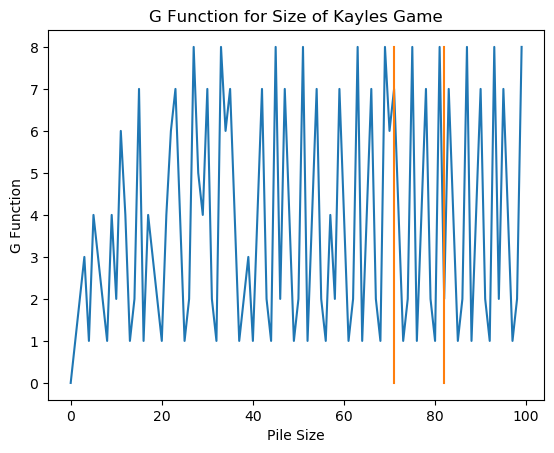

In [147]:
def get_kayles_next_moves(pile):
    next_moves = set()
    if pile >= 1:
        next_moves.add(pile-1)
    if pile >= 2:
        next_moves.add(pile-2)
    if pile >= 3:
        for i in range(1,math.floor((pile-1)/2)+1):
            next_moves.add((i, pile-1-i))
    if pile >= 4:
        for i in range(1,math.floor((pile-2)/2)+1):
            next_moves.add((i, pile-2-i))
    
    return next_moves

def calculate_g_function_from_moves(next_move_fn, max_pile_size):
    g_function = np.zeros(max_pile_size, dtype=int)

    for pile_size in range(max_pile_size):
        next_moves = next_move_fn(pile_size)
        g_values = []
        for move in next_moves:
            if not isinstance(move, tuple):
                g_values.append(g_function[move])
            else:
                g_values.append(nim_sum((g_function[move[0]], g_function[move[1]])))
        
        g_function[pile_size] = mex(g_values)

    return g_function

def find_repetitions(arr):
    index = 0
    max_len = 0
    n = len(arr)

    for i in range(n):
        for j in range(i+1, n, 2):
            rep_len = int((j+1-i)/2)
            if (arr[i:i+rep_len] == arr[i+rep_len:i+2*rep_len]).all():
                if rep_len > max_len:
                    index = i
                    max_len = rep_len
    
    return (index, max_len)

kayles_g_function = calculate_g_function_from_moves(get_kayles_next_moves, 100)
(rep_start, rep_len) = find_repetitions(kayles_g_function)

cmap = plt.get_cmap("tab10")

plt.plot(list(range(100)), kayles_g_function, label="G_function")
plt.title("G Function for Size of Kayles Game")
plt.ylabel("G Function");
plt.xlabel("Pile Size");
plt.plot([rep_start, rep_start], [min(kayles_g_function), max(kayles_g_function)], label="Lower Repetition Bound");
plt.plot([rep_start + rep_len - 1, rep_start + rep_len - 1], [min(kayles_g_function), max(kayles_g_function)], label="Upper Repetition Bound", color=cmap(1))

print("G Function:", str(kayles_g_function))
print("Pattern:", str(kayles_g_function[rep_start:rep_start+rep_len]))
print("Start:", str(rep_start))
print("Length:", str(rep_len))

#### Dawson's Chess

G Function: [0 1 1 2 0 3 1 1 0 3 3 2 2 4 0 5 2 2 3 3 0 1 1 3 0 2 1 1 0 4 5 2 7 4 0 1 1
 2 0 3 1 1 0 3 3 2 2 4 4 5 5 2 3 3 0 1 1 3 0 2 1 1 0 4 5 3 7 4 8 1 1 2 0 3
 1 1 0 3 3 2 2 4 4 5 5 9 3 3 0 1 1 3 0 2 1 1 0 4 5 3 7 4 8 1 1 2 0 3 1 1 0
 3 3 2 2 4 4 5 5 9 3 3 0 1 1 3 0 2 1 1 0 4 5 3 7 4 8 1 1 2 0 3 1 1 0 3 3 2
 2 4]
Pattern: [3 3 0 1 1 3 0 2 1 1 0 4 5 3 7 4 8 1 1 2 0 3 1 1 0 3 3 2 2 4 4 5 5 9]
Start: 52
Length: 34


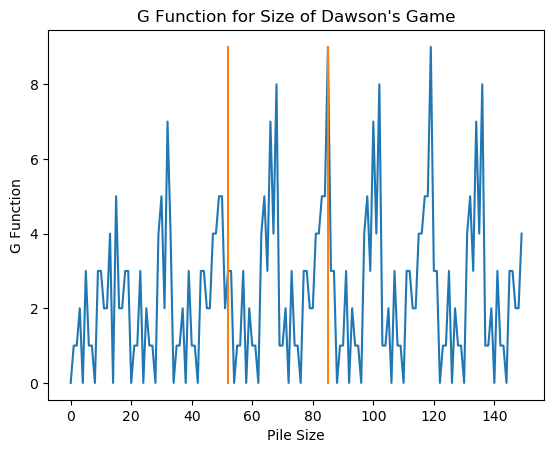

In [134]:
def get_grundy_next_moves(pile):
    next_moves = set()
    if pile == 0:
        return next_moves
    if pile == 1:
        next_moves.add(0)
        return next_moves
    
    next_moves.add(pile-2)
    if pile > 2:
        next_moves.add(pile-3)
        for i in range(1, math.floor((pile-3)/2)+1):
            next_moves.add((i, pile-3-i))

    return next_moves

dawson_g_function = calculate_g_function_from_moves(get_dawson_next_moves, 150)
(rep_start, rep_len) = find_repetitions(dawson_g_function)

plt.plot(list(range(150)), dawson_g_function, label="G_function")
plt.title("G Function for Size of Dawson's Game")
plt.ylabel("G Function");
plt.xlabel("Pile Size");
if rep_len != 1:
    plt.plot([rep_start, rep_start], [min(dawson_g_function), max(dawson_g_function)], label="Lower Repetition Bound");
    plt.plot([rep_start + rep_len - 1, rep_start + rep_len - 1], [min(dawson_g_function), max(dawson_g_function)], label="Upper Repetition Bound", color=cmap(1))

print("G Function:", str(dawson_g_function))
print("Pattern:", str(dawson_g_function[rep_start:rep_start+rep_len]))
print("Start:", str(rep_start))
print("Length:", str(rep_len))


#### Grundy's Game

G Function: [0 0 0 1 0 2 1 0 2 1 0 2 1 3 2 1 3 2 4 3 0 4 3 0 4 3 0 4 1 2 3 1 2 4 1 2 4
 1 2 4 1 5 4 1 5 4 1 5 4 1 0 2 1 0 2 1 5 2 1 3 2 1 3 2 4 3 2 4 3 2 4 3 2 4
 3 2 4 3 2 4 5 2 4 5 2 4 3 7 4 3 7 4 3 7 4 3 5 2 3 5]


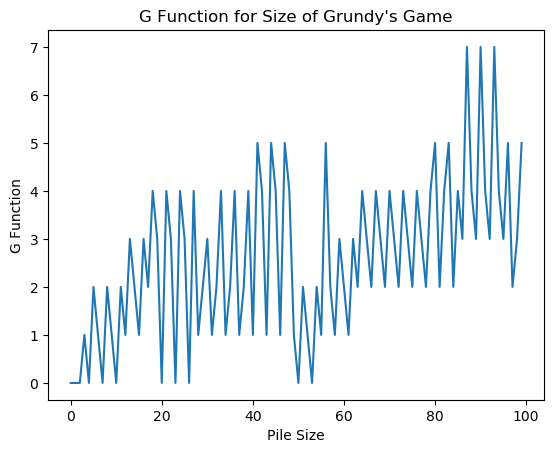

In [149]:
def get_grundy_next_moves(pile):
    next_moves = set()
    if pile > 2:
        for i in range(1,math.ceil(pile/2)):
            next_moves.add((i,pile-i))
    
    return next_moves

grundy_g_function = calculate_g_function_from_moves(get_grundy_next_moves, 100)
(rep_start, rep_len) = find_repetitions(grundy_g_function)

plt.plot(list(range(100)), grundy_g_function, label="G_function")
plt.title("G Function for Size of Grundy's Game")
plt.ylabel("G Function");
plt.xlabel("Pile Size");
print("G Function:", str(grundy_g_function))
# print("Pattern:", str(dawson_g_function[rep_start:rep_start+rep_len]))
# print("Start:", str(rep_start))
# print("Length:", str(rep_len))

There does not appear to be any pattern